False


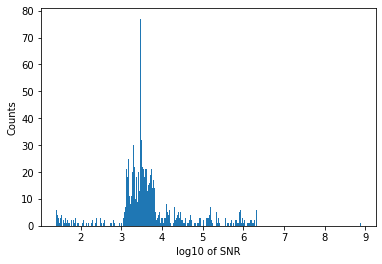

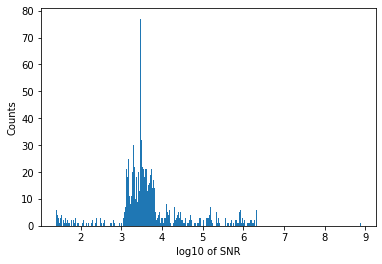

In [152]:
#This notebook is a prototype for a script that will splice individual
#UFUDs into UFSD files. 

#Ellie White, 26 Jan 2021

%matplotlib inline
import numpy as np
import pylab as plt
import sys
import pandas as pd

np.set_printoptions(threshold= sys.maxsize)

#first, read in the .dat files for the first scan in the cadence:
#Need to figure out how to make the filenames more general or at least 
#how to make them work for running on the GBO machine

nodes_list = ['00', '01', '02', '03', '04', '05', '06', '11', \
              '12', '13', '14', '15', '16', '21', '22', '23', \
              '24', '25', '26', '27']

filenames_list = []

for node in nodes_list:
    filename = '/datax/scratch/ewhite/voyager-xband/dat_files/BLC{0}/fine_res/'\
               'blc{0}_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.dat'.format(node)
    filenames_list.append(filename)

#these arrays store data for plotting histograms
dat_info = []
header_lines = []

for fname in filenames_list:
    infile = open(fname, 'r')
    file_header = []

    for line in infile.readlines():
        if line[0] != '#':
            dat_row = line.split()
            
            #get rid of unnecessary whitespace that might
            #cause problems with sorting
            for i in range(len(dat_row)):
                dat_row[i] = dat_row[i].strip()
                
            #append each row to the 2-d dat_info array
            dat_info.append(dat_row)
        else:
            file_header.append(line)
    header_lines.append(file_header)

num_rows = len(dat_info)

'''data = {'TopHitNum': dat_info[:][0],
        'DriftRate': dat_info[:][1],
        'SNR': dat_info[:][2],
        'Freq': dat_info[:][3],
        'ChanInx': dat_info[:][5],
        'FreqStart': dat_info[:][6],
        'FreqEnd': dat_info[:][7],
        'SEFD': dat_info[8],
        'SEFDFreq': dat_info[9],
        'CoarseChanNum': dat_info[10],
        'FullNumHitsInRange': dat_info[11]
        }

dat_info = pd.DataFrame(data)
dat_info = dat_info.apply(pd.to_numeric)

FileID = header_lines[:][0]
Source = header_lines[0][1]

MJD = header_lines[0][2] #hits[4].strip().split('\t')[0].split(':')[-1].strip()
RA =  header_lines[0][3] #hits[4].strip().split('\t')[1].split(':')[-1].strip()
DEC = header_lines[0][4] #hits[4].strip().split('\t')[2].split(':')[-1].strip()

DELTAT = #hits[5].strip().split('\t')[0].split(':')[-1].strip()  # s
DELTAF = #hits[5].strip().split('\t')[1].split(':')[-1].strip()  # Hz'''

dat_info = np.array(dat_info, float)

#sort the rows so they are in order of frequency, descending
freq_index = 4
sorted_dat_info = dat_info[dat_info[:,freq_index].argsort()[::-1]]

#replace Total_Hit_# values so they are unique for each
#row and are natural numbers, matching the turboSETI convention
total_hit_nums = np.arange(1, num_rows+1, 1)
sorted_dat_info[:,0] = total_hit_nums

#address coarse channel numbers
sorted_coarse_chans = []
chan_num = 0

for c in range(num_rows):
    if c == 0:
        sorted_coarse_chans.append(chan_num)
    
    #if there are multiple rows for one coarse channel, the coarse
    #channel number needs to stay the same for all of those rows:
    elif sorted_dat_info[c,10] == sorted_dat_info[(c-1),10]:
        sorted_coarse_chans.append(chan_num)
        
    #if your coarse channel is different from the last one, it needs to be incremented:
    else:
        chan_num += 1
        sorted_coarse_chans.append(chan_num)

sorted_dat_info[:,10] = sorted_coarse_chans

#write spliced .dat file header

outfile_name = 'ufsd_test.dat'

outfile = open(o_fname, 'w')
outfile.write(header_lines[0][0])

for header in header_lines:
    outfile.write(header[1])

outfile.write(header_lines[0][2]+header_lines[0][3]+header_lines[0][4]+header_lines[0][5]+header_lines[0][6]+header_lines[0][7]+header_lines[0][8])

#write rows for spliced .dat file

for r in range(num_rows):
#    outfile.write('{:<{width}}{: }\trow\n'.format(total_hit_nums[r], sorted_dat_info[r,1], width=space_padding))
    
    info_str = '%03d\t'%(int(sorted_dat_info[r,0]))  #Top Hit number
    info_str += '%10.6f\t'%(float(sorted_dat_info[r,1]))  #Drift Rate
    info_str += '%10.6f\t'%(float(sorted_dat_info[r,2]))  #SNR
    info_str += '%14.6f\t'%(float(sorted_dat_info[r,3])) #Uncorrected Frequency:
    info_str += '%14.6f\t'%(float(sorted_dat_info[r,4])) #Corrected Frequency:
    info_str += '%d\t'%(int(sorted_dat_info[r,5])) #Index:
    info_str += '%14.6f\t'%(float(sorted_dat_info[r,6])) #freq_start:
    info_str += '%14.6f\t'%(float(sorted_dat_info[r,7])) #freq_end:
    info_str += '%s\t'%(float(sorted_dat_info[r,8])) #SEFD:
    info_str += '%14.6f\t'%(float(sorted_dat_info[r,9])) #SEFD_mid_freq:
    info_str += '%i\t'%(int(sorted_dat_info[r,10]))
    info_str += '%i\t'%(int(sorted_dat_info[r,11])) #
    info_str +='\n'
    
    outfile.write(info_str)
    
outfile.close()

#get columns from SFD for comparison: (this part can be uncommented if you want to compare
#the columns of our UFSD with the columns of an equivalent SFD)
sfd_fname = '/datax/scratch/ewhite/voyager-xband/spliced_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.dat'
sfd_infile = open(sfd_fname, 'r')

s_dat_info = []

for s_line in sfd_infile.readlines():
    if s_line[0] != '#':
        s_items = s_line.split()

        for num in range(len(s_items)):
            s_items[num] = s_items[num].strip()
        
        s_dat_info.append(s_items)
        
s_dat_info = np.array(s_dat_info, float)
s_sorted_dat_info = s_dat_info[s_dat_info[:,freq_index].argsort()[::-1]]
s_sorted_dat_info[:,0] = total_hit_nums
print(np.array_equal(s_sorted_dat_info[:,2], sorted_dat_info[:,2]))

plt.hist(np.log10(sorted_dat_info[:,2]), bins=500)
plt.xlabel('log10 of SNR')
plt.ylabel('Counts')
plt.savefig('/home/ewhite/snr-comp/ufsd_snr_hist.png', dpi=300)
plt.show()

plt.hist(np.log10(s_sorted_dat_info[:,2]), bins=500)
plt.xlabel('log10 of SNR')
plt.ylabel('Counts')
plt.savefig('/home/ewhite/snr-comp/sfd_snr_hist.png', dpi=300)
plt.show()

outfile_drift_rates = open('/home/ewhite/snr-comp/SFD-vs-UFSD-hits.txt', 'w')
outfile_drift_rates.write('UFSD Hits (D1)\tSFD Hits (D2)\t(D2/D1)\n')

for d in range(num_rows):
    outfile_drift_rates.write('{0}\t\t{1}\t\t{2}\n'.format(sorted_dat_info[d,11], s_sorted_dat_info[d,11], np.divide(s_sorted_dat_info[d,11], sorted_dat_info[d,11])))

outfile_drift_rates.close()
#print(sorted_dat_info[:,2])
#print()
#print(s_sorted_dat_info[:,2])